### Armen Khachatrian
### CS 663 - Machine Learning
#### K-Means

In [2]:
class cluster:

    def __init__(self):
        pass

    def fit(self, X):
        pass

In [3]:
class KMeans(cluster):
    def __init__(self, k = 5, max_iterations = 100):
        self.k = k
        self.max_iterations = max_iterations
        
        
    def init_centroids(self, X):
        #np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.k]]
        return centroids
    
    
    def comp_centroids(self, X, hypotheses):
        centroids = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            centroids[i, :] = np.mean(X[hypotheses == i, :], axis=0)
        return centroids
    
    
    def comp_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            row_norm = norm(X - centroids[i, :], axis=1)
            distance[:, i] = np.square(row_norm)
        return distance
    
    
    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)
    
    
    def fit(self, X):
        self.centroids = self.init_centroids(X)
        centroids_list = []
        hyp_list = []
        for i in range(self.max_iterations):
            old_centroids = self.centroids
            distance = self.comp_distance(X, old_centroids)
            self.hypotheses = self.find_closest_cluster(distance)
            self.centroids = self.comp_centroids(X, self.hypotheses)
            if np.all(old_centroids == self.centroids):
                break
            centroids_list = self.centroids
            hyp_list = self.hypotheses
        return hyp_list,centroids_list
    
    
    def fit_extended(self, X, balanced = False):
        self.balanced = balanced
        if balanced == True:
            self.centroids = self.init_centroids(X)
            labels = -1 * np.ones(X.shape[0], dtype=np.int32)
            mindist = np.infty * np.ones(X.shape[0])
            best_labels, best_inertia, best_centers = None, None, None
            for i in range(self.max_iterations):
                # Init the old cluster centroids
                old_centroids = self.centroids
                distances = self.comp_distance(X, old_centroids)
                for point_id in np.arange(X.shape[0]):
                    # Sort points by distance
                    sorted_points = sorted([(a, b) for a, b in enumerate(distances.T[:, point_id])],
                                           key=lambda x: x[1])

                    # Initial assignment of labels and mindist
                    # Here we put the threshold of size
                    for cluster_id, point_dist in sorted_points:
                        if not (len(np.where(labels==cluster_id)[0]) >= X.shape[0]//self.k):
                            labels[point_id], mindist[point_id] = cluster_id, point_dist
                            break
                    
                transfer_list = [] #for point correspondings
                best_mindist = mindist.copy()
                best_labels = labels.copy()
        
                # Points by distance (from highest to lowest)
                for point_id in np.argsort(mindist)[::-1]:
                    point_cluster = labels[point_id]

                    # see if there is an opening on the best cluster for this point
                    cluster_id, point_dist = sorted([(a, b) for a, b in enumerate(distances.T[:, point_id])],
                                                    key=lambda x: x[1])[0]

                    if not ((len(np.where(labels==cluster_id)[0]) >= X.shape[0]//self.k) and
                        (point_cluster != cluster_id)):
                        labels[point_id], mindist[point_id] = cluster_id, point_dist
                        best_labels, best_mindist = labels.copy(), mindist.copy()
                        continue
                    # iterate through candidates in the transfer list
                    for swap_candidate_id in transfer_list:
                        if point_cluster != labels[swap_candidate_id]:
                            # calculate the current distance of swap candidate
                            cand_distance = mindist[swap_candidate_id]

                            # find the potential distance of point
                            point_distance = distances.T[labels[swap_candidate_id], point_id]

                            # proceeed if transfer will improve distance
                            if point_distance < cand_distance:
                                labels[point_id] = labels[swap_candidate_id]
                                mindist[point_id] = distances.T[labels[swap_candidate_id], point_id]
                                labels[swap_candidate_id] = point_cluster
                                mindist[swap_candidate_id] = distances.T[point_cluster, swap_candidate_id]

                                if np.abs(mindist).sum() <  np.abs(best_mindist).sum():
                                    # update the labels since the transfer was a success
                                    best_labels, best_mindist = labels.copy(), mindist.copy()
                                    break
                                else:
                                    # reset since the transfer was not a success
                                    labels, mindist = best_labels.copy(), best_mindist.copy()

                    # Add point to transfer list
                    transfer_list.append(point_id)

                # Calculate final intertia
                inertia = best_mindist.sum()
                labels = best_labels

                # Recalculate centers 
                centers = []
                for group_id in range(self.k):
                    centers.append(np.mean(X[np.where(best_labels == group_id)[0]], 0))
                centers = np.array(centers)

                # UPDATE RETURN VALUES
                if best_inertia is None or inertia < best_inertia:
                    best_labels = labels.copy()
                    best_centers = centers.copy()
                    best_inertia = inertia

            # Test group sizes and raise AssertionError on non-uniform group sizes
            best_group_sizes = [len(np.where(best_labels == group_id)[0]) for
                                group_id in range(self.k)]
            assert best_group_sizes == [len(X) // self.k] * self.k
            return best_centers, best_labels, best_group_sizes
        else:
            self.centroids = self.init_centroids(X)
            centroids_list = []
            hyp_list = []
            for i in range(self.max_iterations):
                old_centroids = self.centroids
                distance = self.comp_distance(X, old_centroids)
                self.hypotheses = self.find_closest_cluster(distance)
                self.centroids = self.comp_centroids(X, self.hypotheses)
                if np.all(old_centroids == self.centroids):
                    break
                centroids_list = self.centroids
                hyp_list = self.hypotheses
            group_sizes = [len(np.where(self.hypotheses == group_id)[0]) for
                            group_id in range(self.k)]
            return hyp_list,centroids_list, group_sizes

>Example:

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

from sklearn.datasets.samples_generator import make_blobs
X, cluster_assignments = make_blobs(n_samples=200, centers=4, cluster_std=0.60, random_state=0)

>fit ():

In [11]:
model= KMeans(k=4, max_iterations=100)
fit_centroids = model.fit(X)[1]
fit_hypotheses = model.fit(X)[0]
print('Centroids: ', fit_centroids)
print('Label Hypotheses: ', fit_hypotheses)

Centroids:  [[ 0.90793962  4.35713791]
 [-1.62401415  2.9159629 ]
 [ 2.07187892  0.97422926]
 [-1.34842715  7.72096548]]
Label Hypotheses:  [2 3 1 0 2 1 3 1 1 1 1 2 3 3 2 1 0 0 0 2 0 3 2 3 2 2 0 2 2 1 0 1 3 2 3 1 3
 1 1 0 0 0 0 1 2 3 1 0 0 1 0 3 3 0 1 0 3 2 1 2 0 1 2 1 0 1 2 0 3 3 2 2 1 1
 3 0 3 3 2 2 0 1 2 3 3 1 1 2 3 3 0 0 0 1 1 2 3 0 1 1 0 2 2 0 0 3 1 2 2 1 0
 3 3 2 2 1 3 3 0 1 0 3 1 2 1 3 1 3 2 1 3 2 3 0 0 3 0 0 2 0 2 3 2 2 3 2 1 2
 3 0 0 0 1 3 2 1 0 3 0 2 0 2 2 3 3 0 1 2 2 3 2 1 3 0 0 0 1 1 3 1 3 2 1 2 1
 3 3 0 1 0 2 2 1 0 3 3 3 1 0 2]


> fit_extended(balanced = True)

In [13]:
print('Centroids for fit_extended(True)', model.fit_extended(X, balanced =True)[0]) 
print('Label Hypotheses for fit_extended(True)', model.fit_extended(X, balanced =True)[1]) 
print('Best cluster sizes for fit_extended(True)', model.fit_extended(X, balanced =True)[2]) 

Centroids for fit_extended(True) [[ 2.06118278  1.01718475]
 [-1.604148    3.08649097]
 [ 0.87811963  4.17896102]
 [-1.32777718  7.68565882]]
Label Hypotheses for fit_extended(True) [1 3 1 0 3 1 2 1 1 1 1 1 2 2 1 1 0 0 0 1 0 3 3 3 1 1 0 3 3 1 0 1 3 1 3 1 3
 1 1 0 0 0 0 1 3 2 1 0 0 1 0 3 2 0 1 0 3 3 1 1 0 1 1 1 0 1 1 0 2 3 1 3 1 1
 2 0 2 2 1 1 0 1 1 3 2 1 1 3 3 2 0 0 0 1 1 1 2 0 1 1 0 1 1 0 0 3 1 1 1 1 0
 2 2 3 3 3 3 2 0 2 0 2 2 3 2 2 3 2 3 3 2 3 3 0 0 2 0 0 3 0 3 2 3 2 2 3 2 3
 2 0 0 0 2 2 3 2 0 2 0 2 0 3 3 3 3 0 3 3 3 2 3 2 2 0 0 0 2 2 2 2 2 3 2 3 2
 2 2 0 2 0 3 3 3 0 2 2 2 2 0 3]
Best cluster sizes for fit_extended(True) [50, 50, 50, 50]


> fit_extended(balanced = False)

In [16]:
print('Centroids for fit_extended(False)', model.fit_extended(X, balanced =False)[1]) 
print('Label Hypotheses for fit_extended(False)', model.fit_extended(X, balanced =False)[0]) 
print('Best cluster sizes for fit_extended(False)', model.fit_extended(X, balanced =False)[2]) 

Centroids for fit_extended(False) [[-1.62401415  2.9159629 ]
 [-1.34842715  7.72096548]
 [ 0.90793962  4.35713791]
 [ 2.07187892  0.97422926]]
Label Hypotheses for fit_extended(False) [0 1 2 3 0 2 1 2 2 2 2 0 1 1 0 2 3 3 3 0 3 1 0 1 0 0 3 0 0 2 3 2 1 0 1 2 1
 2 2 3 3 3 3 2 0 1 2 3 3 2 3 1 1 3 2 3 1 0 2 0 3 2 0 2 3 2 0 3 1 1 0 0 2 2
 1 3 1 1 0 0 3 2 0 1 1 2 2 0 1 1 3 3 3 2 2 0 1 3 2 2 3 0 0 3 3 1 2 0 0 2 3
 1 1 0 0 2 1 1 3 2 3 1 2 0 2 1 2 1 0 2 1 0 1 3 3 1 3 3 0 3 0 1 0 0 1 0 2 0
 1 3 3 3 2 1 0 2 3 1 3 0 3 0 0 1 1 3 2 0 0 1 0 2 1 3 3 3 2 2 1 2 1 0 2 0 2
 1 1 3 2 3 0 0 2 3 1 1 1 2 3 0]
Best cluster sizes for fit_extended(False) [22, 50, 97, 31]


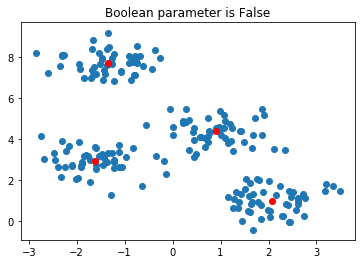

In [18]:
plt.scatter(X[:,0], X[:,1])
centroids_cluster = model.fit_extended(X, balanced =False)[1]
plt.scatter(centroids_cluster[:,0], centroids_cluster[:,1], c='red')
plt.title('Boolean parameter is False')
plt.show()

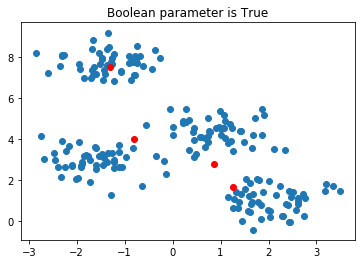

In [24]:
plt.scatter(X[:,0], X[:,1])
centroids_cluster = model.fit_extended(X, balanced =True)[0]
plt.scatter(centroids_cluster[:,0], centroids_cluster[:,1], c='red')
plt.title('Boolean parameter is True')
plt.show()

In [36]:
from sklearn import metrics 
metrics.v_measure_score(cluster_assignments, model.fit(X)[0])

1.0

### Conclusion: